# Objective

Based on the data from WHO stroke is considered as the second leading cause of global death, which is around 11% of the total death. In this assignment we are trying to create a ML model that can predict the possibility of having a stroke in a patient based on a set of features like age, gender, heart diseaes and other health conditions.

The infromation about the patient is represented in each row and the class labels are represented by 0 and 1. Were 1 represents the patient had stroke and 0 represents no previous stroke history.Since there are only two classes and the class labels are known, this is a supervised learning binary class clssification problem and we are using the popular classification algorithms like decision tree, random forest etc for building the model.

In [1]:
# importing the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import  classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn import decomposition
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from numpy import mean

import warnings
warnings.filterwarnings("ignore")


## Loading the dataset

In [4]:
#uloading the dataset using pandas, the dataset is in csv formnat

stroke_data =  pd.read_csv(r"C:\Users\renji\Downloads\archive (1)\healthcare-dataset-stroke-data.csv")
print(stroke_data.shape)

(5110, 12)


In [5]:
# Describing the dataset

stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
# printing the headers

stroke_data.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
#checking the class distribution

stroke_data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

The dataset have 11 features and 5110 data points. There are both catagorical and numerical values in features so we have to convert the catagorical values into numerical values before feeding into the model. Also the bmi feature has null values, need to handle those missing values during feature engineering stage.

While checking the class distribution it is clear that the dataset is highily imbalanced, with 4861 data points belongs to majority class and only 249 data points in the minority class. Techniques will be used to balanave the dataset prior to the classification.

# Feature Engineering

### Encoding the Catagorical data

Features that have catagorical values are :  
'gender','ever_married','Residence_type','work_type','smoking_status'

Here the One-Hot encoding with get_dummies() were used to convert the catagorical values. In this function each catagorical values were converted into seperate columns and the orginal column is used for further process 

In [59]:
#One-Hot encoding the categorical parameters using get_dummies()

encoded_Stroke_data = pd.get_dummies(stroke_data, columns = ['gender','ever_married','Residence_type','work_type','smoking_status'])
encoded_Stroke_data = pd.DataFrame(encoded_Stroke_data)

column_names = ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'Residence_type_Rural',
       'Residence_type_Urban', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'stroke']

encoded_Stroke_data = encoded_Stroke_data.reindex(columns=column_names)
encoded_Stroke_data

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,9046,67.0,0,1,228.69,36.6,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
1,51676,61.0,0,0,202.21,NaN,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
2,31112,80.0,0,1,105.92,32.5,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
3,60182,49.0,0,0,171.23,34.4,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,1665,79.0,1,0,174.12,24.0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,NaN,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
5106,44873,81.0,0,0,125.20,40.0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5107,19723,35.0,0,0,82.99,30.6,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5108,37544,51.0,0,0,166.29,25.6,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0


### Handling Missing Values

In [60]:
# checking the missing values in features

encoded_Stroke_data.isnull().sum()

id                                  0
age                                 0
hypertension                        0
heart_disease                       0
avg_glucose_level                   0
bmi                               201
gender_Female                       0
gender_Male                         0
gender_Other                        0
ever_married_No                     0
ever_married_Yes                    0
Residence_type_Rural                0
Residence_type_Urban                0
work_type_Govt_job                  0
work_type_Never_worked              0
work_type_Private                   0
work_type_Self-employed             0
work_type_children                  0
smoking_status_Unknown              0
smoking_status_formerly smoked      0
smoking_status_never smoked         0
smoking_status_smokes               0
stroke                              0
dtype: int64

In [70]:
# There are 201 missing values in bmi
# Here the Multivariate feature imputation method is used to handle the missing values

imp = IterativeImputer()
stroke_imp_data = imp.fit_transform(encoded_Stroke_data)

#Converting to Pandas DataFrame

stroke_imp_data = pd.DataFrame(stroke_imp_data)


In [85]:
#Renaming the columns

stroke_imp_data.rename(columns = {0:'id', 1:'age', 2:'hypertension',3: 'heart_disease', 4:'avg_glucose_level',
       5:'bmi',6: 'gender_Female',7: 'gender_Male',8: 'gender_Other',
       9:'ever_married_No', 10:'ever_married_Yes',11: 'Residence_type_Rural',
       12:'Residence_type_Urban',13: 'work_type_Govt_job', 14:'work_type_Never_worked',
       15:'work_type_Private', 16:'work_type_Self-employed',17: 'work_type_children',
       18:'smoking_status_Unknown', 19:'smoking_status_formerly smoked',
       20:'smoking_status_never smoked', 21:'smoking_status_smokes',22: 'stroke'}, inplace = True)
stroke_imp_data

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,9046.0,67.0,0.0,1.0,228.69,36.600000,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,51676.0,61.0,0.0,0.0,202.21,31.127421,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,31112.0,80.0,0.0,1.0,105.92,32.500000,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,60182.0,49.0,0.0,0.0,171.23,34.400000,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1665.0,79.0,1.0,0.0,174.12,24.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234.0,80.0,1.0,0.0,83.75,32.320744,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5106,44873.0,81.0,0.0,0.0,125.20,40.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5107,19723.0,35.0,0.0,0.0,82.99,30.600000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5108,37544.0,51.0,0.0,0.0,166.29,25.600000,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [63]:
#checking for missing values

stroke_imp_data.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
dtype: int64

## EDA

### Feature analysis using EDA

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

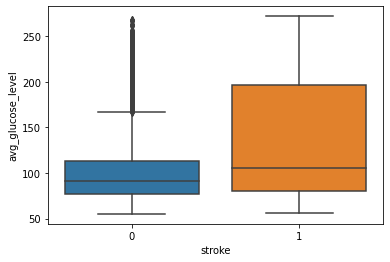

In [50]:
#Avg_glucose_level
X_data = stroke_data.drop(['stroke'], axis=1)
y = stroke_data['stroke']
sns.boxplot(data = X_data,y =stroke_data['avg_glucose_level'],x = y)

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

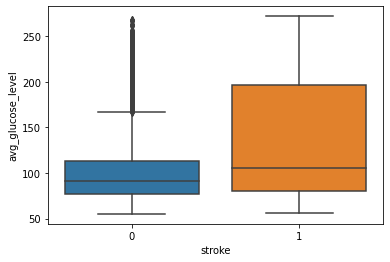

In [64]:
#Age

sns.boxplot(data = X_data,y =stroke_data['avg_glucose_level'],x = y)

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

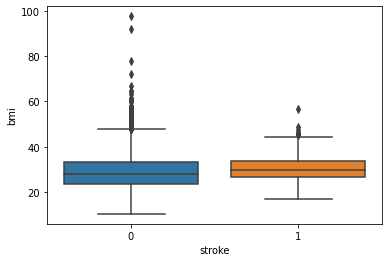

In [65]:
#BMI

sns.boxplot(data = X_data,y =stroke_data['bmi'],x = y)

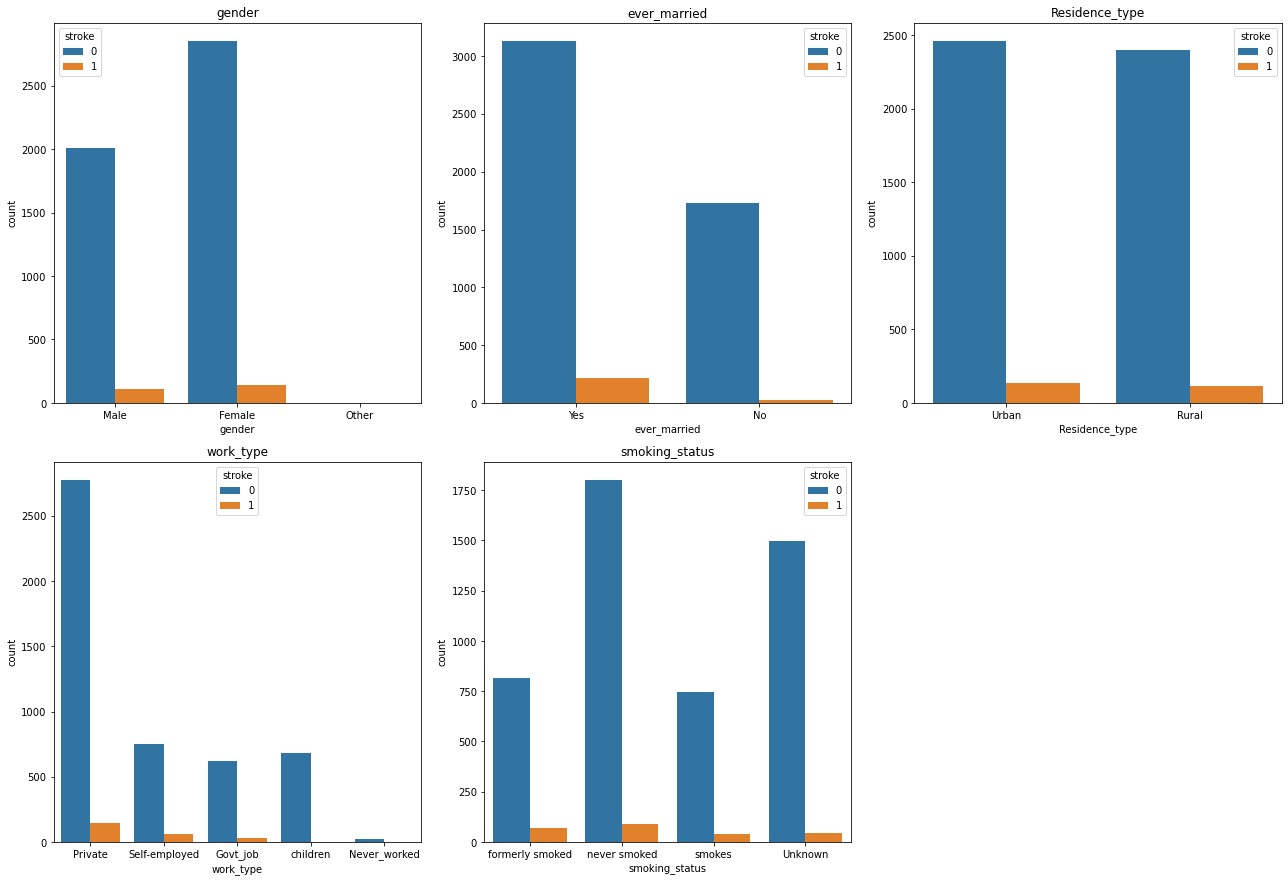

In [79]:
#Histogram for catagorical features

Features =['gender','ever_married','Residence_type','work_type','smoking_status']
plt.figure(figsize= (18,18))
for i ,col in enumerate(Features):
    plt.subplot(3,3,i+1)
    sns.countplot(x=col, hue='stroke', palette='tab10', data=stroke_data)
    plt.title(col)
plt.tight_layout()
plt.show()

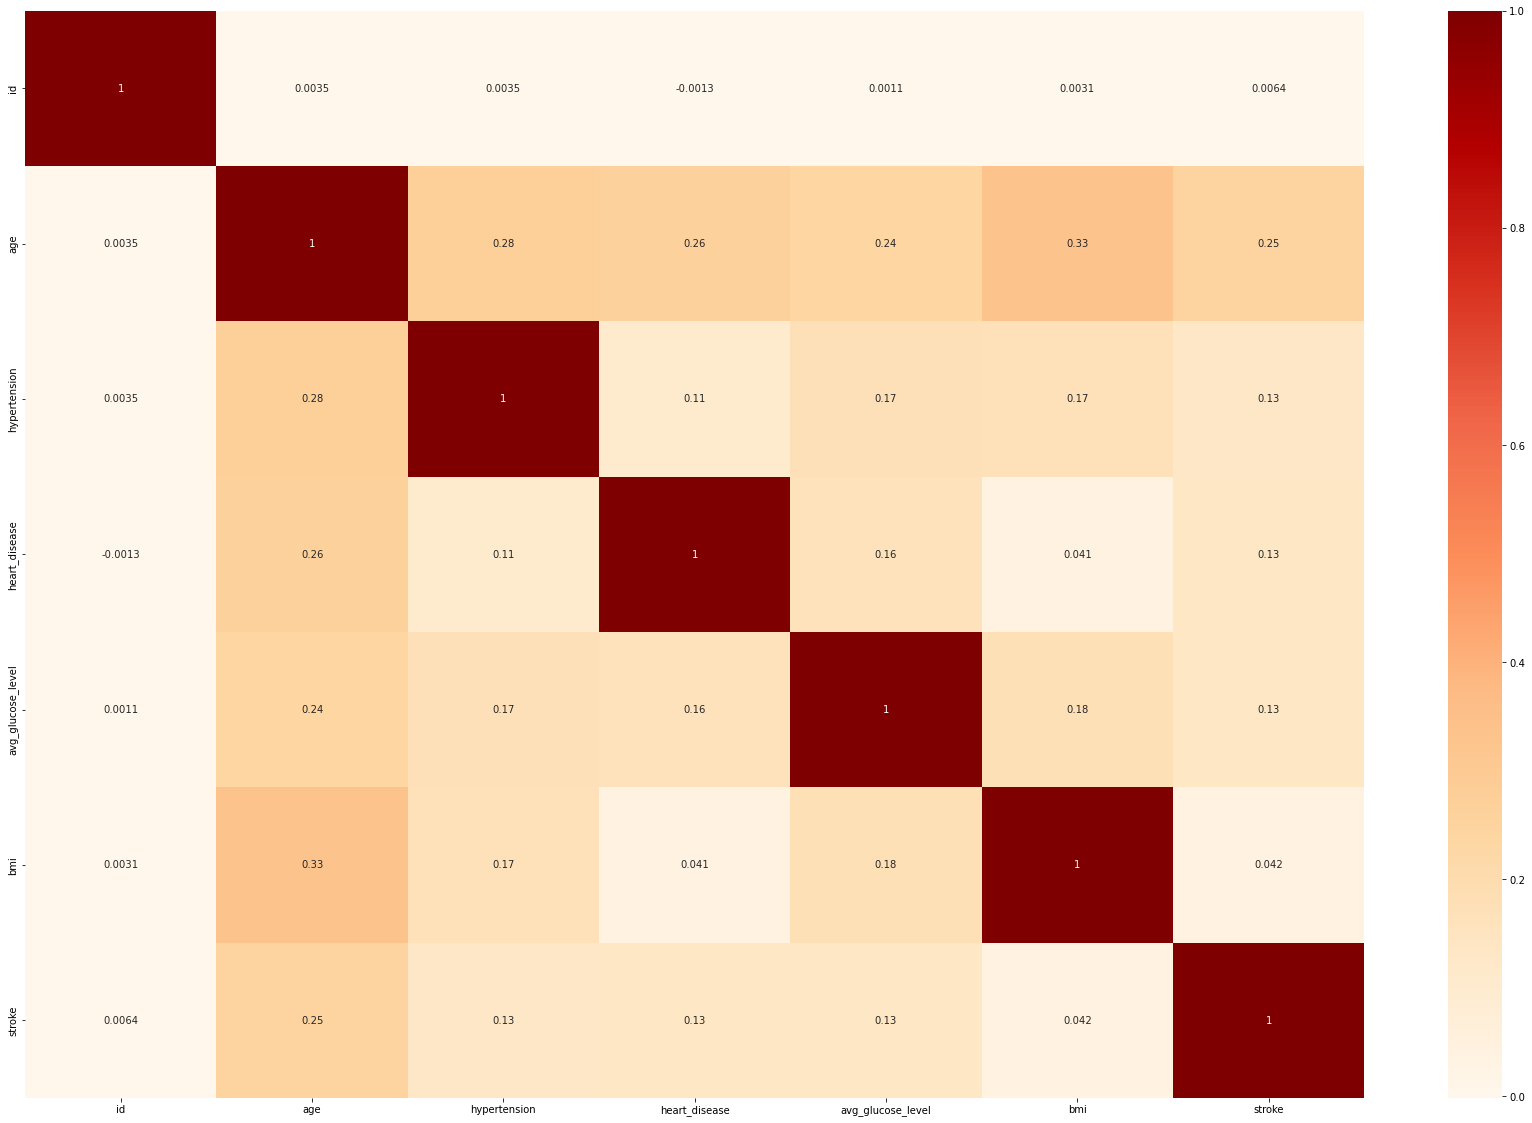

In [81]:
#creating a correlation matrix
plt.figure(figsize=(30,20))
sns.heatmap(stroke_data.corr(),annot = True,cmap ='OrRd')
plt.show()


### Balancing the Dataset

The dataset is an imbalanced one with more than 95% of data belongs to majority class, which is 'No stroke History' in this case. There are differnt methods used to handle the unbalanced dataset. Here the Oversampling method is used. In this method Duplicate datapoints are created from the minority class and adding to dataset inorder to match with the majority class

([<matplotlib.patches.Wedge at 0x23d49f1a820>,
 [Text(-1.0871361453364168, 0.16773491438301516, 'Had Stroke'),
  Text(1.087136143373357, -0.1677349271061446, 'No Stroke History')],
 [Text(-0.5929833520016818, 0.09149177148164463, '95.1%'),
  Text(0.592983350930922, -0.0914917784215334, '4.9%')])

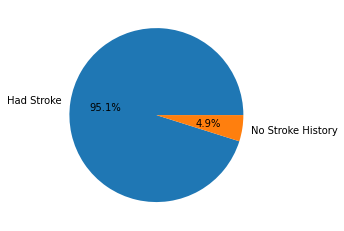

In [110]:
# plotting the class distribution

clas_names = ['Had Stroke','No Stroke History']
clas_count = stroke_imp_data['stroke'].value_counts()
plt.pie(clas_count,labels = clas_names,autopct='%1.1f%%')

In [210]:

X = stroke_imp_data.drop(['stroke','id'],axis = 1)
y = stroke_imp_data['stroke']

# using the RandomOverSampler Function to perform the Oversampling

Over_sampling = RandomOverSampler(random_state=42)
Over_sampling.fit(X, y)
X_balanced, y_balanced = Over_sampling.fit_resample(X, y)
y_balanced.value_counts()

1.0    4861
0.0    4861
Name: stroke, dtype: int64

([<matplotlib.patches.Wedge at 0x23d4bbd2370>,
 [Text(6.735557395310444e-17, 1.1, 'Had Stroke'),
  Text(-2.0206672185931328e-16, -1.1, 'No Stroke History')],
 [Text(3.6739403974420595e-17, 0.6, '50.0%'),
  Text(-1.1021821192326178e-16, -0.6, '50.0%')])

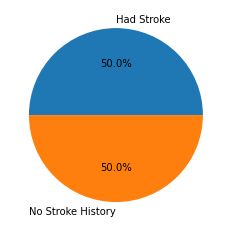

In [127]:
#plotting the pie diagarm after balancing the dataset

#plotting a pie diagram

class_names = ['Had Stroke','No Stroke History']
class_count = y_balanced.value_counts()
plt.pie(class_count,labels = class_names,autopct='%1.1f%%')

## Model Creation

In [211]:
# Spliting the dataset into training and testing data

X_train,X_test,y_train,y_test =train_test_split(X_balanced,y_balanced,test_size = 0.2,random_state = 42)

# scaleing the independent variables
scalar = StandardScaler()

#scaling the testing and training dataset
scalar.fit(X_train)
X_train_scaled = pd.DataFrame(scalar.transform(X_train))
scalar.fit(X_test)
X_test_scaled = pd.DataFrame(scalar.transform(X_test))

In [212]:
#Creating the models

models =  {
   
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "                         Random Forest": RandomForestClassifier(),                    
}


#fitting the models

for clsfr,clsfr_fun in models.items():
    clsfr_fun.fit(X_train_scaled,y_train)

#Test score and cross validation

cross_valid = KFold(n_splits=5, random_state=1, shuffle=True)

print('Test Score')

for clr,clr_funtion in models.items():
    scores = cross_val_score(clr_funtion, X_balanced, y_balanced, scoring='accuracy', cv=cross_valid, n_jobs=-1)
    per_score = mean(scores)
    print(clr  ,": {:.2f}%". format(per_score*100))

Test Score
                   K-Nearest Neighbors : 92.89%
                         Decision Tree : 97.63%
                         Random Forest : 99.11%


In [213]:
#Classification report for RandomForestClassifier

# Spliting the dataset into traing and testing data

X_train1,X_test1,y_train1,y_test1 =train_test_split(X_balanced,y_balanced,test_size = 0.2,random_state = 42)

# scaleing the independent variables
scalar = StandardScaler()

#scaling the testing and training dataset
scalar.fit(X_train1)
X_train_scaled1 = pd.DataFrame(scalar.transform(X_train1))
scalar.fit(X_test1)
X_test_scaled1 = pd.DataFrame(scalar.transform(X_test1))

print('Test Score')

model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled1,y_train1)
prediction1 = model.predict(X_test_scaled1)

score1 = model.score(X_test_scaled1,y_test1)
per_score1 =  (": {:.2f}%". format(score1*100))
print(clsfr, ' : ' ,(per_score1))
    
print('Classification Report for RandomForestClassifier : ','\n')
print(classification_report(y_test1,prediction1))



Test Score
                         Random Forest  :  : 99.28%
Classification Report for RandomForestClassifier :  

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       975
         1.0       0.99      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945



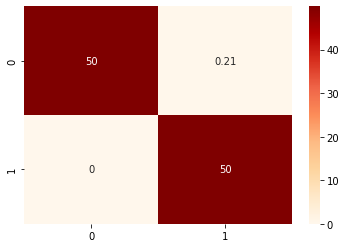

In [209]:
#confusion matrix

conf_matrix = confusion_matrix(y_test1,prediction1)
plt.figure(figsize=(6,4))
sns.heatmap((conf_matrix/np.sum(conf_matrix))*100,annot = True,cmap ="OrRd")
plt.show()